In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares


In [2]:
frwd_swaprate=  pd.read_csv("df_ForwardSwap.csv")    #import the forward swap rates 

In [3]:
rates=pd.read_csv("df_comb.csv")  #From part 1

In [4]:
IVs=pd.read_excel("IR Data.xlsx",sheet_name="Swaption")

In [5]:
IVs.columns=IVs.iloc[1]

In [6]:
IVs.drop([0,1],inplace=True)

In [7]:
IVs.dropna(how="any",axis=1,inplace=True)
IVs.reset_index(inplace=True)
IVs.drop("index",axis=1,inplace=True)

In [8]:
IVs["Expiry"]=IVs["Expiry"].map(lambda x:int(x[:-1]))
IVs["Tenor"]=IVs["Tenor"].map(lambda x:int(x[:-1]))


In [9]:
IVs.iloc[:,2:]=IVs.iloc[:,2:]/100

In [10]:
IVs.head() #cleaned dataframe

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.9157,0.6203,0.4413,0.31224,0.26182,0.225,0.2096,0.214,0.2434,0.27488,0.30297
1,1,2,0.8327,0.6124,0.4657,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1,3,0.7392,0.5687,0.4477,0.35745,0.32317,0.2978,0.2829,0.278,0.2877,0.30725,0.32833
3,1,5,0.5519,0.4464,0.3651,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1,10,0.4118,0.3504,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355


In [11]:
strikes=IVs.copy(deep=True)
for i in range(2,13):
    strikes.iloc[:,i]=frwd_swaprate["Swap_Rate"]

In [12]:
strikes.iloc[:,2]=strikes.iloc[:,2]-0.02
strikes.iloc[:,3]=strikes.iloc[:,3]-0.015
strikes.iloc[:,4]=strikes.iloc[:,4]-0.01
strikes.iloc[:,5]=strikes.iloc[:,5]-0.005
strikes.iloc[:,6]=strikes.iloc[:,6]-0.0025
strikes.iloc[:,12]=strikes.iloc[:,12]+0.02
strikes.iloc[:,11]=strikes.iloc[:,11]+0.015
strikes.iloc[:,10]=strikes.iloc[:,10]+0.01
strikes.iloc[:,9]=strikes.iloc[:,9]+0.005
strikes.iloc[:,8]=strikes.iloc[:,8]+0.0025



In [13]:
strikes.head()

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.011950,0.016950,0.021950,0.026950,0.029450,0.031950,0.034450,0.036950,0.041950,0.046950,0.051950
1,1,2,0.013200,0.018200,0.023200,0.028200,0.030700,0.033200,0.035700,0.038200,0.043200,0.048200,0.053200
2,1,3,0.013947,0.018947,0.023947,0.028947,0.031447,0.033947,0.036447,0.038947,0.043947,0.048947,0.053947
3,1,5,0.015184,0.020184,0.025184,0.030184,0.032684,0.035184,0.037684,0.040184,0.045184,0.050184,0.055184
4,1,10,0.018335,0.023335,0.028335,0.033335,0.035835,0.038335,0.040835,0.043335,0.048335,0.053335,0.058335


In [14]:
rates.head()

,Unnamed: 0,Tenor (year),LIBOR Discount Factor,IRS Rate,OIS Rate,OIS Discount Factor,OIS Overnight Rate,Forward LIBOR
0,0,0.5,0.987654,0.025,0.00250,0.997506,0.004994,0.025000
1,1,1.0,0.972579,0.028,0.00300,0.997009,0.000997,0.031001
2,2,1.5,0.957406,NaN,NaN,0.995270,NaN,0.031695
3,3,2.0,0.942234,0.030,0.00325,0.993531,0.003495,0.032205
4,4,2.5,0.926412,NaN,NaN,0.991773,NaN,0.034157


In [15]:
def impliedVolatility(F,K,T,exp,tenor,price):
    impliedVol = brentq(lambda x: price -
                                Black76Lognormal(F,K,T,x,exp,tenor),
                                -1, 1)
    return impliedVol





def PVBP(exp, tenor):
    
        
    return sum(0.5*rates[(rates["Tenor (year)"]>exp)& (rates["Tenor (year)"]<=tenor+exp)].reset_index()["OIS Discount Factor"])
 




def Black76Lognormal(F,K,T,sigma,exp,tenor):
    d1 = (np.log(F/K)+(sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return F*PVBP(exp,tenor)*norm.cdf(d1) - K*PVBP(exp,tenor)*norm.cdf(d2)

def Displaced_Diffusion(F, K, T, sigma, beta,exp,tenor):
    return Black76Lognormal(F/beta, K+(1-beta)/beta*F, T,sigma*beta,exp,tenor)

In [16]:

prices=IVs.copy(deep=True)
for i in IVs.index:
    for j in range(2,13):
     prices.iloc[i,j]=Black76Lognormal(frwd_swaprate.iloc[i,3],strikes.iloc[i,j],IVs.iloc[i,0],IVs.iloc[i,j],IVs.iloc[i,0],IVs.iloc[i,1])
    

In [17]:
prices.head(3)

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.021089,0.016028,0.011202,0.00664,0.004574,0.002846,0.001688,0.001078,0.000583,0.000385,0.00028
1,1,2,0.041916,0.032283,0.023055,0.014496,0.010713,0.007526,0.005156,0.003606,0.002049,0.001367,0.001001
2,1,3,0.061992,0.047901,0.034384,0.021969,0.016536,0.011944,0.008419,0.005967,0.003312,0.002111,0.001481


# Displaced Diffusion Calibration

In [18]:
def Displaced_Diffusion_Calibration(x, strikes, prices,F , T,exp,tenor):  
    err = 0.0
    for i, price in enumerate(prices):
        err += (price -  Displaced_Diffusion(F,strikes[i] , T, x[0], x[1],exp,tenor))**2
            
    return err

In [19]:

DD_sigma=pd.DataFrame(index=IVs.index,columns=["Expiry","Tenor","Sigma"])
DD_beta=pd.DataFrame(index=IVs.index,columns=["Expiry","Tenor","Beta"])
for i in IVs.index:
    
      res = least_squares(lambda x: Displaced_Diffusion_Calibration(x,
                                             strikes.iloc[i,2:],
                                             prices.iloc[i,2:],
                                             frwd_swaprate.iloc[i,3],
                                             IVs.loc[i,"Expiry"],IVs.iloc[i,0],IVs.iloc[i,1]),[0.5,0.2],bounds=([0,0],[np.inf,1]))

      DD_sigma.iloc[i,:]=[IVs.iloc[i,0],IVs.iloc[i,1],res.x[0]]
      DD_beta.iloc[i,:]=[IVs.iloc[i,0],IVs.iloc[i,1],res.x[1]]




In [20]:
DD_sigma.pivot(columns=["Tenor"],values=["Sigma"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Sigma                                        
Tenor         1         2         3         5         10
Expiry                                                  
1       0.403533   0.36408  0.333147  0.290906  0.252791
5       0.307549  0.313167  0.308511  0.270026  0.247566
10      0.299765   0.29814   0.29442  0.265845  0.242922

In [21]:
DD_beta.pivot(columns=["Tenor"],values=["Beta"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Beta                                        
Tenor         1         2         3         5         10
Expiry                                                  
1       0.199527  0.199186  0.199027  0.199487  0.200042
5        0.19851  0.198085  0.365238  0.345473  0.339199
10      0.693301  0.254392  0.236005  0.306846  0.263825

# SABR Calibration

In [22]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma


In [23]:
def sabr_calibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.9, x[1], x[2]))**2
    return err

In [24]:
SABR_alpha=pd.DataFrame(index=IVs.index,columns=["Expiry","Tenor","Alpha"])
SABR_rho=pd.DataFrame(index=IVs.index,columns=["Expiry","Tenor","Rho"])
SABR_nu=pd.DataFrame(index=IVs.index,columns=["Expiry","Tenor","Nu"])




for i in IVs.index:
    
    res=least_squares(lambda x: sabr_calibration(x,
                                           strikes.iloc[i,2:],
                                           IVs.iloc[i,2:],
                                           frwd_swaprate.iloc[i,3],
                                           IVs.loc[i,"Expiry"]),
                          [0.1,-0.5,0.5],
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
    SABR_alpha.iloc[i,:]=[IVs.iloc[i,0],IVs.iloc[i,1],res.x[0]]
    SABR_rho.iloc[i,:]=[IVs.iloc[i,0],IVs.iloc[i,1],res.x[1]]
    SABR_nu.iloc[i,:]=[IVs.iloc[i,0],IVs.iloc[i,1],res.x[2]]



In [25]:
SABR_alpha.pivot(columns=["Tenor"],values=["Alpha"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Alpha                                        
Tenor         1         2         3         5         10
Expiry                                                  
1        0.13907   0.18467  0.196865  0.178058  0.170885
5       0.166565  0.199577  0.210419  0.191207  0.176905
10      0.177864  0.195343  0.207011  0.201826    0.1801

In [26]:
SABR_rho.pivot(columns=["Tenor"],values=["Rho"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Rho                                        
Tenor         1         2         3         5         10
Expiry                                                  
1      -0.632628 -0.524618 -0.482388 -0.413979 -0.264429
5      -0.584666 -0.546609 -0.549566 -0.511825 -0.435195
10      -0.54616  -0.54409  -0.54984 -0.563144  -0.50674

In [27]:
SABR_nu.pivot(columns=["Tenor"],values=["Nu"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Nu                                        
Tenor         1         2         3         5         10
Expiry                                                  
1       2.044468  1.673683  1.434889   1.06221  0.778427
5       1.336231  1.059156  0.933945  0.668863  0.495281
10      1.005595  0.923107  0.866072  0.717836  0.578153

In [28]:
SABR_alpha.pivot(columns=["Tenor"],values=["Alpha"],index=["Expiry"]).to_csv("SABR_Alpha.csv")

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [29]:
SABR_rho.pivot(columns=["Tenor"],values=["Rho"],index=["Expiry"]).to_csv("SABR_Rho.csv")

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [30]:
SABR_nu.pivot(columns=["Tenor"],values=["Nu"],index=["Expiry"]).to_csv("SABR_Nu.csv")

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


# Payer Swaption 2y × 10y 

In [31]:
ks=np.arange(0.01,0.09,0.01) #The strikes for pricing

In [32]:
ks

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])

In [33]:
#Forward rate today, for a collateralized market:

S_0=sum(rates[(rates["Tenor (year)"]>2.0)& (rates["Tenor (year)"]<=12.0)].reset_index()["OIS Discount Factor"]*
    rates[(rates["Tenor (year)"]>=2.0)& (rates["Tenor (year)"]<12.0)].reset_index()["Forward LIBOR"]*0.5)/PVBP(2,10)

In [34]:
S_0

0.038921965824554754

## DD

In [35]:
from scipy import interpolate

In [36]:
DD_sigma=DD_sigma.pivot(columns=["Tenor"],values=["Sigma"],index=["Expiry"])
DD_beta=DD_beta.pivot(columns=["Tenor"],values=["Beta"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [37]:
#Finding the interpolated values of the DD paramters

DD_sigma_interp=interpolate.interp1d([1,5],[DD_sigma.iloc[0,4],DD_sigma.iloc[1,4]] )(2)
DD_beta_interp=interpolate.interp1d([1,5],[DD_beta.iloc[0,4],DD_beta.iloc[1,4]] )(2)


In [38]:
DD_Prices=[Displaced_Diffusion(S_0, i, 2, DD_sigma_interp, DD_beta_interp,2,10) for i in ks]

In [39]:
DD_Prices_Frame=pd.DataFrame(DD_Prices,index=ks)
DD_Prices_Frame.index.name="Strike"
DD_Prices_Frame.columns=["Price"]

In [40]:
DD_Prices_Frame

,Price
Strike,
0.01,0.280981
0.02,0.187665
0.03,0.106403
0.04,0.048657
0.05,0.017419
0.06,0.004852
0.07,0.001062
0.08,0.000186


## SABR

In [41]:
SABR_alpha=SABR_alpha.pivot(columns=["Tenor"],values=["Alpha"],index=["Expiry"])
SABR_rho=SABR_rho.pivot(columns=["Tenor"],values=["Rho"],index=["Expiry"])
SABR_nu=SABR_nu.pivot(columns=["Tenor"],values=["Nu"],index=["Expiry"])

/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/vp/Downloads/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [42]:
SABR_alpha_interp=interpolate.interp1d([1,5],[SABR_alpha.iloc[0,4],SABR_alpha.iloc[1,4]] )(2)
SABR_rho_interp=interpolate.interp1d([1,5],[SABR_rho.iloc[0,4],SABR_rho.iloc[1,4]] )(2)
SABR_nu_interp=interpolate.interp1d([1,5],[SABR_nu.iloc[0,4],SABR_nu.iloc[1,4]] )(2)


In [43]:
SABR_prices=[Black76Lognormal(S_0,i,2,SABR(S_0, i, 2, SABR_alpha_interp, 0.9, SABR_rho_interp, SABR_nu_interp
                                          ),2,10) for i in ks]

In [44]:
SABR_prices

[0.282725596352163,
 0.19158350783088895,
 0.10907945219740559,
 0.047966259694047,
 0.019552510779955568,
 0.00995262762149001,
 0.00620259176890757,
 0.00437988762155549]

In [45]:
SABR_Prices_Frame=pd.DataFrame(SABR_prices,index=ks)
SABR_Prices_Frame.index.name="Strike"
SABR_Prices_Frame.columns=["Price"]

In [46]:
SABR_Prices_Frame

,Price
Strike,
0.01,0.282726
0.02,0.191584
0.03,0.109079
0.04,0.047966
0.05,0.019553
0.06,0.009953
0.07,0.006203
0.08,0.004380


# Receiver Swaption 8y × 10y

In [47]:
def Black76Lognormal_Rec(F,K,T,sigma,exp,tenor):
    d1 = (np.log(F/K)+(sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return -F*PVBP(exp,tenor)*norm.cdf(-d1) + K*PVBP(exp,tenor)*norm.cdf(-d2)

def Displaced_Diffusion_Rec(F, K, T, sigma, beta,exp,tenor):
    return Black76Lognormal_Rec(F/beta, K+(1-beta)/beta*F, T,sigma*beta,exp,tenor)

In [48]:
S_0=S_0=sum(rates[(rates["Tenor (year)"]>8.0)& (rates["Tenor (year)"]<=18.0)].reset_index()["OIS Discount Factor"]*
    rates[(rates["Tenor (year)"]>=8.0)& (rates["Tenor (year)"]<18.0)].reset_index()["Forward LIBOR"]*0.5)/PVBP(8,10)

In [49]:
S_0

0.047533569736034766

## DD

In [50]:
DD_sigma_interp=interpolate.interp1d([5,10],[DD_sigma.iloc[1,4],DD_sigma.iloc[2,4]] )(8)
DD_beta_interp=interpolate.interp1d([5,10],[DD_beta.iloc[1,4],DD_beta.iloc[2,4]] )(8)


In [51]:
DD_Prices=[Displaced_Diffusion_Rec(S_0, i, 8, DD_sigma_interp, DD_beta_interp,8,10) for i in ks]

In [52]:
DD_Prices

[0.012324697685209315,
 0.02726321700020365,
 0.05194486456504943,
 0.08797546380377574,
 0.13572569406479518,
 0.19443481782393024,
 0.26258124754878454,
 0.3383146175375069]

In [53]:
DD_Prices_Frame=pd.DataFrame(DD_Prices,index=ks)
DD_Prices_Frame.index.name="Strike"
DD_Prices_Frame.columns=["Price"]

In [54]:
DD_Prices_Frame

,Price
Strike,
0.01,0.012325
0.02,0.027263
0.03,0.051945
0.04,0.087975
0.05,0.135726
0.06,0.194435
0.07,0.262581
0.08,0.338315


## SABR

In [55]:
SABR_alpha_interp=interpolate.interp1d([5,10],[SABR_alpha.iloc[1,4],SABR_alpha.iloc[2,4]] )(8)
SABR_rho_interp=interpolate.interp1d([5,10],[SABR_rho.iloc[1,4],SABR_rho.iloc[2,4]] )(8)
SABR_nu_interp=interpolate.interp1d([5,10],[SABR_nu.iloc[1,4],SABR_nu.iloc[2,4]] )(8)

In [56]:
SABR_prices=[Black76Lognormal_Rec(S_0,i,8,SABR(S_0, i, 8, SABR_alpha_interp, 0.9, SABR_rho_interp, SABR_nu_interp
                                          ),8,10) for i in ks]

In [57]:
SABR_prices

[0.019246268894794128,
 0.038540962718442956,
 0.06156963741829678,
 0.09149229888930614,
 0.1332020527636567,
 0.19136925629967533,
 0.2646546582664178,
 0.3471196648889908]

In [58]:
SABR_Prices_Frame=pd.DataFrame(SABR_prices,index=ks)
SABR_Prices_Frame.index.name="Strike"
SABR_Prices_Frame.columns=["Price"]

In [59]:
SABR_Prices_Frame

,Price
Strike,
0.01,0.019246
0.02,0.038541
0.03,0.061570
0.04,0.091492
0.05,0.133202
0.06,0.191369
0.07,0.264655
0.08,0.347120


# Implied Vol Graphs

In [60]:
Expiry=np.array(["1Y","5Y","10Y"])
Tenor=np.array(["1Y","2Y","3Y","5Y","10Y"])
s=np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])

In [61]:
SABR_alpha.columns=[1,2,3,5,10]
SABR_rho.columns=[1,2,3,5,10]
SABR_nu.columns=[1,2,3,5,10]


In [62]:
DD_sigma.columns=[1,2,3,5,10]
DD_beta.columns=[1,2,3,5,10]


In [63]:
IVs[(IVs["Expiry"]==1)&(IVs["Tenor"]==1)].iloc[:,2:].values.shape

(1, 11)

In [64]:
def impliedVol(S, K, price, T, Beta,exp,tenor):
    impliedVol = brentq(lambda x: price - 
                        Displaced_Diffusion(S, K,  T, 1,x, ),
                        1e-6, 1)
    return impliedVol

IndexError: index 5 is out of bounds for axis 0 with size 5

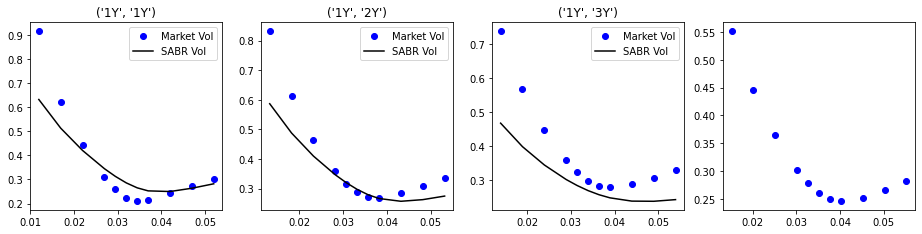

In [65]:
for ex in Expiry:
    fig=plt.figure(figsize=(20,20))
    ax=plt.axes()
    ax=plt.title('Tenor=%s' %j)
    for te,i in zip(Tenor,range(5)):
        ax=plt.subplot(551+i)
        ATM=frwd_swaprate[(frwd_swaprate["Expiry"]==ex)&(frwd_swaprate["Tenor"]==te)]["Swap_Rate"].values[0]
        strikes=s*0.0001+ATM
        T=int(ex[:-1])
        ax=plt.plot(strikes,IVs[(IVs["Expiry"]==int(ex[:-1]))&(IVs["Tenor"]==int(te[:-1]))].iloc[:,2:].values.reshape(11,)
                    ,'bo',label='Market Vol')
        ax=plt.plot(strikes,
                    [SABR(ATM,x,T,SABR_alpha.iloc[int(ex[:-1]),int(te[:-1])],0.9,SABR_rho.iloc[int(ex[:-1]),int(te[:-1])]
                          ,SABR_nu.iloc[int(ex[:-1]),int(te[:-1])]) for x in strikes],
                    'k',label='SABR Vol')
        
        price_DD=[Displaced_Diffusion(ATM,x,T, DD_sigma.iloc[int(ex[:-1]),int(te[:-1])],DD_beta.iloc[int(ex[:-1]),int(te[:-1])],
                                      int(ex[:-1]),int(te[:-1]) ) for i,x in zip(range(len(strikes)),strikes)]
        
        ax=plt.title((ex,te))
        ax=plt.legend()
    plt.show()
    
(F, K, T, sigma, beta,exp,tenor)